In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import os
import pandas as pd
import librosa as lb
from librosa import display
import scipy

In [2]:
"""
Attribute Information:

Description of raw_data _*** file 
Each file consist of 10 columns: 
1) Time - time in ms; 
2-9) Channel - eightEMG channels of MYO Thalmic bracelet; 
10) Class â€“thelabel of gestures: 
0 - unmarked data, 
1 - hand at rest, 
2 - hand clenched in a fist, 
3 - wrist flexion, 
4 - wrist extension, 
5 - radial deviations, 
6 - ulnar deviations, 
7 - extended palm (the gesture was not performed by all subjects).
"""

'\nAttribute Information:\n\nDescription of raw_data _*** file \nEach file consist of 10 columns: \n1) Time - time in ms; \n2-9) Channel - eightEMG channels of MYO Thalmic bracelet; \n10) Class â€“thelabel of gestures: \n0 - unmarked data, \n1 - hand at rest, \n2 - hand clenched in a fist, \n3 - wrist flexion, \n4 â€“ wrist extension, \n5 â€“ radial deviations, \n6 - ulnar deviations, \n7 - extended palm (the gesture was not performed by all subjects).\n'

In [464]:
def load_random_sample(path):
    """load a random sample from the dataset
    
    Arguments:
    
    path : string, path to the dataset
    
    """
    infos = next(os.walk(path + '/'))
    root = infos[0]
    folders = infos[1]
    index = np.random.randint(0,len(folders)-1)
    files = os.listdir(os.path.join(root , folders[index]))
    index2 = np.random.randint(0,len(files)-1)
    data = pd.read_csv(os.path.join(root , folders[index] , files[index2]), sep='\t')
    data.columns = ['time', 'channel_1','channel_2','channel_3',
                    'channel_4','channel_5','channel_6','channel_7', 'channel_8', 'labels']
    
    return data
    
    

In [465]:
def load_sample(path):
    """load a specific sample from the raw dataset
    
    Arguments:
    
    path : string, path to the sample in the raw dataset
    
    """
    
    data = pd.read_csv(path, sep='\t')
    data.columns = ['time', 'channel_1','channel_2','channel_3',
                    'channel_4','channel_5','channel_6','channel_7', 'channel_8', 'labels']
    
    return data
    
    

In [535]:
path = '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/EMG_data_for_gestures-master'

In [399]:
def plot_sample(data, channels):
    """Plots the selected channels of the sample data
    
    Arguments:
    
    data : DataFrame, a single sample in the dataset
    channels : list, a list of integers between 0 and 7
    
    """
    
    time = data['time']
    n = len(channels)
    for i in channels:
        plt.subplot(str(n) + '1' + str(i))
        plt.plot(time, data['channel_' + str(i)], 'k', alpha = 0.75)
    for j in range(1,8):
        try:
            for k in channels:
                plt.subplot(str(n) + '1' + str(k))
                inds = np.hstack(np.where(data['labels'] == j)[0])
                plt.plot(time[inds], data['channel_' + str(k)][inds],'o' ,alpha = 0.15)  
        except:
            pass
            
    #plt.tight_layout()
    plt.show()

    


In [635]:
def extend_labeled_region(sample, insertL = 500):
    """Extend a labeled region of the EGM data
    
    Arguments:
    
    sample    : pandas dataframe representating a sample loaded with load_sample() or load_random_sample()
    insertL : int, magnitude of the extension on each side of the region
    """
    labels = set(sample['labels'])
    
    for j in list(labels)[1:]:
        try:
            inds = np.hstack(np.where(sample['labels'] == j)[0])
            inds = np.insert(inds,0,np.arange(inds[0]-insertL, inds[0]))
            jumps = np.hstack(np.where(np.diff(inds) > 2)[0])
            for jump in jumps:
                refLow = inds[jump-1]
                refHigh = inds[jump+1]
                #insert at the end of the first region
                inds = np.insert(inds, jump-1, np.arange(inds[jump-1], inds[jump-1] + insertL))
                #insert at the beginning of the second region
                inds = np.insert(inds, jump+1 + insertL, np.arange(inds[jump+1+insertL] - insertL, inds[jump+1+insertL]))
                #insert at the end of the second region
                inds = np.insert(inds, len(inds), np.arange(inds[-1] , inds[-1] + insertL))  
            sample['labels'].values[inds] = j
        except:
            print(f'no label = {j}')

    return sample




In [710]:
def create_single_sample(file,index):
    """Loads raw data and splits it into labeled regions creating a sample
    
    Arguments:
    
    file    : string, path to the raw data txt
    index   : int, number of the raw data file used for naming
    """    
    save_root = '/Users/Copo1/Documents/PYTHON_code/DataScience_projects/GestureRecognition/CustomDataset'
    sample = load_sample(file)
    sample = extend_labeled_region(sample)
    
    for label in list(set(sample['labels']))[1:]:
        try:
            inds = np.hstack(np.where(sample['labels'] == label)[0])
        except:
            print('bad sample')
            return False
            
            
        jumps = np.hstack(np.where(np.diff(inds) > 2)[0])
        for channel in range(1,9):
            key = 'channel_' + str(channel)
            #isolate first repeat of gesture
            data1 = sample[key][inds[:jumps[0]]]
            #isolate second repeat of gesture
            data2 = sample[key][inds[jumps[0]+1:len(inds)]]
            #clip the lenght at 2500 and if shorter pad with zeros
            try:
                data1 = data1[:2500]
            except:
                data1 = np.pad(data1,(0,2500-len(data1)))
                print('shortdata')
            try:
                data2 = data2[:2500]
            except:
                data2 = np.pad(data2,(0,2500-len(data2)))
                print('shortdata')
            #save each repeat in the labeled folder in the database
            np.savetxt(os.path.join(save_root,str(int(label)),''.join([key,'_',str(index).zfill(3),'.txt'])), data1)
            np.savetxt(os.path.join(save_root,str(int(label)),''.join([key,'_',str(index+1).zfill(3),'.txt'])), data2)
    return True


In [681]:
#get all the txt files in the raw data
files = [y for x in os.walk(path) for y in glob.glob(os.path.join(x[0], '*.txt'))]

In [705]:
#create empty dirs corresponding to the labels
for i in range(1,8):
    os.mkdir(str(i))

In [706]:
# runs over all files and saves each processed sample to create the custom dataset
k = 1
for file in files[1:]:
    res = create_single_sample(file,k)
    print(res)
    if res:
        k = k+2

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
no label = nan
bad sample
False
True
True
True
True
True


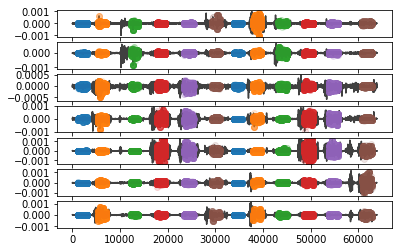

no label = 7


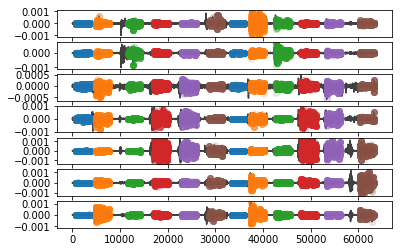

In [467]:
sample = load_random_sample(path)
plot_sample(sample,list(([1,2,3,4,5,6,7])))
plt.figure()
sample = extend_labeled_region(sample)
plot_sample(sample,list(([1,2,3,4,5,6,7])))




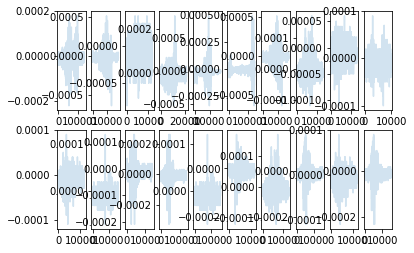

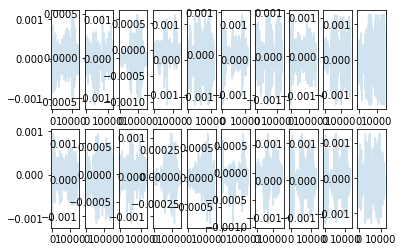

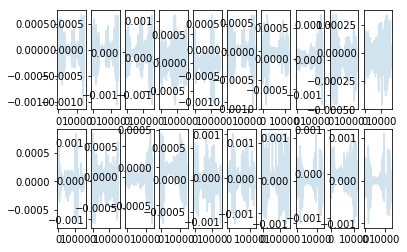

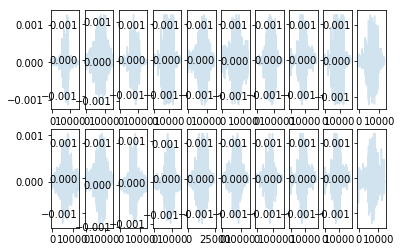

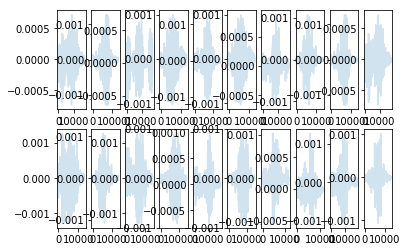

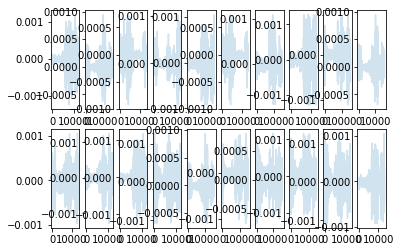

In [179]:
# experiments to see what kind of features the data presents
labels = [1,2,3,4,5,6]
lens=[]
#loop over all possible gestures
for label in labels:
    fig = plt.figure()
    
    # loop over 10 random samples
    for j in range(20):
        
        #load a random sample from the dataset
        sample = load_random_sample(path)
        
        #quick and dirty flags
        flag = 0
        datatmp = 1
        
        #loop over MYO channels
        for i in range(1,9):
            # finds where the first repeat of the gesture (label) ends
            inds = np.hstack(np.where(sample['labels'] == label)[0])
            jumps = np.hstack(np.where(np.diff(inds) > 2)[0])

            if flag: # only the first channel
                datatmp = (sample['channel_' + str(i)][sample['labels'] == label][:jumps[0]].values)
            else:
                data = (sample['channel_' + str(i)][sample['labels'] == label][:jumps[0]].values)
                flag = 1
            # concatenate together each channel in a single timeserie
            if i>1:
                data = np.insert(data,len(data),datatmp)

        ax = fig.add_subplot(2, 20/2, j+1)
        #ax.set_ylim([1,1.005])
        ax.plot(np.arange(len(data)),data,alpha = 0.2)
        lens.append(len(data))

plt.show()

# fro each sample we did the following:
#    - isolated the segments of the signal corresponding to each gesture for each channel
#    - concatenated the isolated segments coming form each channel into a single serie
# from the concatenated series it looks like each gesture presents some "feature".I am going to create a dataset of such concatenated series.

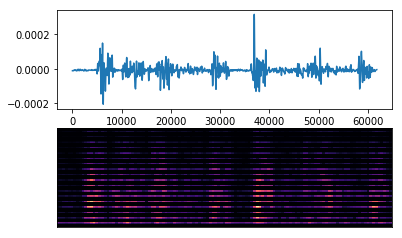

In [171]:
plt.subplot(211)
plt.plot(scipy.ndimage.gaussian_filter( sample['channel_1'],50))
plt.subplot(212)
S = lb.feature.melspectrogram(scipy.ndimage.gaussian_filter( sample['channel_1'],50),fmax=200)
display.specshow((S**(1/4)))

In [23]:
inds0 = np.where(sample['labels']==0)[0]

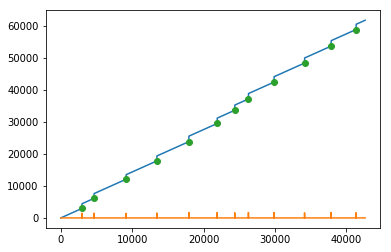

In [37]:
plt.plot(inds0)
plt.plot(np.diff(inds0))
plt.plot(np.hstack(np.where(np.diff(inds0)>2)[0]), np.hstack((inds0[np.where(np.diff(inds0)>2)[0]])),'o')
plt.show()

### experiments on nn structure

In [186]:
import cv2
import torch.nn as nn

In [235]:
m = nn.Conv1d(16, 33, 1, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [228]:
output

tensor([[[-0.3108, -0.3108, -0.3108,  ..., -0.3108, -0.3108, -0.3108]]],
       grad_fn=<SqueezeBackward1>)

In [266]:
inp = torch.FloatTensor(np.array([[data]]))
m = nn.Conv1d(1, 6, 1000, stride=2)
p = nn.MaxPool1d(2,2)
n = nn.Conv1d(6, 16, 1000, stride=2)
q = nn.MaxPool1d(2,2)
output = q(n(p(m(inp))))